In [1]:
# Import module
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class MelCepstrum(Dataset):
    def __init__(self,  file, transform=None):
        self.datas = pd.read_csv(file)
        self.transform = transform

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, index):
        path = 'music_train/' + self.datas.iloc[index, 0]
        image = Image.open(path).convert('RGB')
        label = torch.tensor(int(self.datas.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
BATCH_SIZE = 32
EPOCHS = 12
num_classes = 88

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [6]:
dataset = MelCepstrum(file='train_truth.csv', transform=transform)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [8]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128) 
        self.fc2 = nn.Linear(128, num_classes) 
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train_epoch(model, dataloader, loss_fn, optimizer, device) -> float:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)  # Number of batches per epoch
    train_loss, train_correct = 0.0, 0.0
    model.train()  # Set model to training mode
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)  # Forward propagation
        loss = loss_fn(output, y)  # Calculate loss
        train_loss += loss.item()  # Accumulate loss
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_correct += (output.argmax(1) == y).type(torch.float).sum().item()

    return train_loss/num_batches, 100*train_correct/size  # Return average loss

In [10]:
def valid_epoch(model, dataloader, loss_fn, device) -> float:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)  # Number of batches per epoch
    valid_loss, valid_correct = 0.0, 0.0
    model.eval()  # Set model to evaluation mode
    with torch.inference_mode(mode=True):
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            output = model(x)  # Get model prediction
            loss = loss_fn(output, y)  # Calculate loss
            valid_loss += loss.item()  # Accumulate loss
            valid_correct += (output.argmax(1) == y).type(torch.float).sum().item()
    return valid_loss/num_batches, 100*valid_correct/size  # Return average loss

In [11]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device):
    # Initializes a defaultdict to store the training and validation losses at each epoch
    result = defaultdict(list)
    # Moved the model to the specified device
    model.to(device)
    # Iterates through each epoch
    for epoch in tqdm(range(1, epochs + 1)):
        # Train the model and calculate the training loss
        train_loss, train_acc = train_epoch(
            model, train_loader, loss_fn, optimizer, device)
        # Calculate the validation loss
        valid_loss, valid_acc = valid_epoch(model, valid_loader, loss_fn, device)
        # Appended the training and validation losses to the result
        result['train_loss'].append(train_loss)
        result['train_accuracy'].append(train_acc)
        result['valid_loss'].append(valid_loss)
        result['valid_accuracy'].append(valid_acc)
        print(f"Epoch: {epoch} Train accuracy: {train_acc} Train loss: {train_loss} Valid accuracy: {valid_acc} Valid loss: {valid_loss}")
    return result  # Return the training and validation losses at each epoch


In [12]:
model = CNN_Model()
model = model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002)

In [13]:
def plot(result):
    # Get the number of epochs
    epochs = range(len(result['train_loss']))
    # Create a new figure for the plot
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    # Set the title of the plot
    plt.title('Training and Validation Accuracy')
    # Set the label for the x-axis
    plt.xlabel('Epochs')
    # Set the label for the y-axis
    plt.ylabel('Accuracy')
    # Plot the training loss over epochs
    plt.plot(epochs, result['train_accuracy'], label='train accuracy')
    # Plot the validation loss over epochs
    plt.plot(epochs, result['valid_accuracy'], label='valid accuracy')
    # Add a legend to the plot
    plt.legend()

    plt.subplot(1, 2, 2)
    # Set the title of the plot
    plt.title('Training and Validation Loss')
    # Set the label for the x-axis
    plt.xlabel('Epochs')
    # Set the label for the y-axis
    plt.ylabel('Loss')
    # Plot the training loss over epochs
    plt.plot(epochs, result['train_loss'], label='train loss')
    # Plot the validation loss over epochs
    plt.plot(epochs, result['valid_loss'], label='valid loss')
    # Add a legend to the plot
    plt.legend()

    plt.tight_layout()
    # Save the plot
    plt.savefig('Training and Validation History.png')
    # Display the plot
    plt.show()

In [14]:
result = train(model, train_loader, val_loader, loss_fn, optimizer, EPOCHS, device)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 Train accuracy: 6.07429718875502 Train loss: 4.230232802648393 Valid accuracy: 26.229508196721312 Valid loss: 3.3491796917385526
Epoch: 2 Train accuracy: 66.36546184738955 Train loss: 1.533611279749681 Valid accuracy: 93.91100702576112 Valid loss: 0.3525843835539288
Epoch: 3 Train accuracy: 98.29317269076306 Train loss: 0.10446223086633143 Valid accuracy: 98.94613583138174 Valid loss: 0.04256706084642145
Epoch: 4 Train accuracy: 99.64859437751004 Train loss: 0.01981257714168538 Valid accuracy: 100.0 Valid loss: 0.0066521331943847515
Epoch: 5 Train accuracy: 100.0 Train loss: 0.003565428468088309 Valid accuracy: 100.0 Valid loss: 0.002824257261602691
Epoch: 6 Train accuracy: 100.0 Train loss: 0.001661279854098601 Valid accuracy: 100.0 Valid loss: 0.0018410727304096024
Epoch: 7 Train accuracy: 100.0 Train loss: 0.0012002568059076098 Valid accuracy: 100.0 Valid loss: 0.0013218023544781048
Epoch: 8 Train accuracy: 100.0 Train loss: 0.0008882029431997725 Valid accuracy: 100.0 Valid

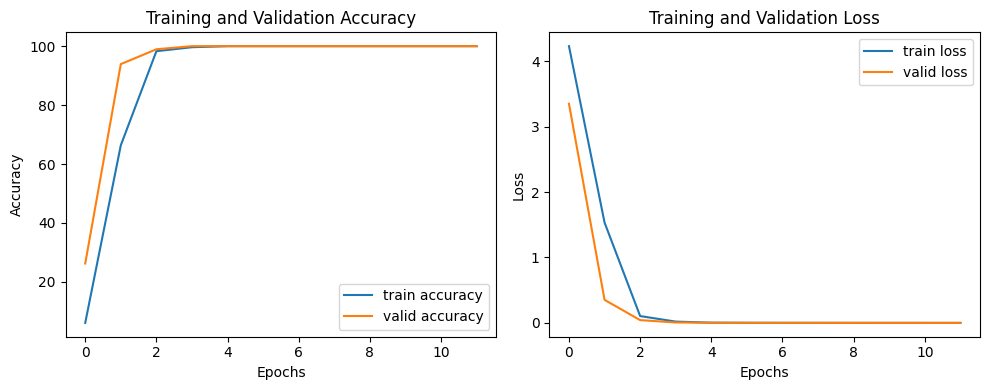

In [15]:
plot(result)

In [16]:
test_imgs = os.listdir('music_test')
model.eval()
outputs = []


for img_file in test_imgs:
    path = os.path.join('music_test', img_file)
    img = Image.open(path).convert('RGB')
    test_img = transform(img).unsqueeze(0).to(device) 
    output = model(test_img)
    _, predicted = torch.max(output.data, 1)
    predicted = predicted.cpu().numpy().tolist()
    outputs.append([img_file[:],predicted[0]])

submission = pd.DataFrame(outputs, columns=['filename', 'category'])
submission.to_csv('submission.csv', index=False)